### **Necessary imports**

In [1]:
import numpy as np
import pandas as pd
import string

#%matplotlib inline
#from matplotlib import pyplot as plt
#plt.style.use('fivethirtyeight')

import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks
from keras.layers import Dense, Flatten, Embedding, LSTM, GRU, Dropout, Activation, Input

from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots

2023-02-14 17:37:18.958524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 17:37:19.091393: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 17:37:19.091413: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 17:37:19.677390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### **Dataset**

In [2]:
df = pd.read_csv(r'questions.csv')
df.columns =['text', 'target']
print("Name: ", (df.target == 1).sum()) # Name
print("No Name: ", (df.target == 0).sum()) # No Name
display(df)



Name:  41
No Name:  218


,text,target
0,What is your name?,1
1,Who are you?,1
2,What's your name?,1
3,Can I have your name?,1
4,Can you tell me your name?,1
...,...,...
254,Thank you,0
255,Goodbye,0
256,How can you help me?,0
257,what can you do?,0


In [3]:
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation.replace("'", ""))
    return text.translate(translator)

### **Preprocessing**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size=0.2, random_state=2023, stratify=df.target)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023, stratify=y_train) # 0.25 x 0.8 = 0.2

In [5]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_train = y_train.to_numpy()
Y_test = y_test.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

In [6]:
maxLen = len(max(X_train, key=len).split()) + 5
maxLen

22

### **Tokenizer**

In [7]:
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`. 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    lst=[]
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().replace("can't", " can not")\
                            .replace("n't", " not")\
                            .replace("'s", " is")\
                            .replace("'ll", " will")\
                            .replace("'ve", " have")\
                            .replace("'re", " are")\
                            .replace("'m", " am")\
                            .replace("'d", " would")\
                            .replace("-", " ")\
                            .replace("\x97", " ")\
                            .split()
              
        # Initialize j to 0
        j = 0

        # Loop over the words of 
        
        for w in sentence_words:
            # print(remove_punct(w.lower()))
            if remove_punct(w.lower()) in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.

                X_indices[i, j] = word_to_index[remove_punct(w.lower())]

                # Increment j to j + 1
                j = j + 1
            else:
                lst.append(w)
                j = j + 1

    return X_indices

### **The Embedding layer**

In [8]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [9]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [10]:
# GRADED FUNCTION: pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [11]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

2023-02-14 17:37:26.017766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-14 17:37:26.017823: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-14 17:37:26.017845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-2RMTEVU): /proc/driver/nvidia/version does not exist
2023-02-14 17:37:26.018101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 17:37:26.054685: W tensorflow/tsl/framework/cpu_allocator

weights[0][1][3] = -0.3403


### **Building the model**

In [12]:
def convert_to_one_hot(y):
    """
    converts y into one hot reprsentation.

    Parameters
    ----------
    y : list
        A list containing continous integer values.

    Returns
    -------
    one_hot : numpy.ndarray
        A numpy.ndarray object, which is one-hot representation of y.

    """
    max_value = max(y)
    min_value = min(y)
    length = len(y)
    one_hot = np.zeros((length, (max_value - min_value + 1)))
    one_hot[np.arange(length), y] = 1
    return one_hot 

In [13]:
# GRADED FUNCTION: Classify

def Classify(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Classify model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)    
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(64, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with sigmoid activation
    X = Dense(2)(X)
    # Add a sigmoid activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [14]:
X_train_indice = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train)

X_val_indice = sentences_to_indices(X_val, word_to_index, maxLen)
Y_val_oh = convert_to_one_hot(y_val)


model = Classify((maxLen,), word_to_vec_map, word_to_index)
model.summary()

2023-02-14 17:37:27.120862: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 80000200 exceeds 10% of free system memory.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 22, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 22, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 22, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130   

In [15]:
model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# earlyStopCallBack = callbacks.EarlyStopping(monitor='val_loss', patience=23,restore_best_weights = True,mode ="min", verbose=1)
earlyStopCallBack = callbacks.EarlyStopping(monitor='val_loss',patience=15,restore_best_weights = True)
history= model.fit(X_train_indice, Y_train_oh, validation_data=(X_val_indice, Y_val_oh), epochs = 70 , batch_size = 20, callbacks=earlyStopCallBack)

Epoch 1/70
9/9 [==============================] - 5s 187ms/step - loss: 0.5706 - accuracy: 0.7758 - val_loss: 0.4718 - val_accuracy: 0.8333
Epoch 2/70
9/9 [==============================] - 1s 58ms/step - loss: 0.4529 - accuracy: 0.8424 - val_loss: 0.4530 - val_accuracy: 0.8333
Epoch 3/70
9/9 [==============================] - 1s 66ms/step - loss: 0.4510 - accuracy: 0.8424 - val_loss: 0.4511 - val_accuracy: 0.8333
Epoch 4/70
9/9 [==============================] - 0s 48ms/step - loss: 0.4471 - accuracy: 0.8424 - val_loss: 0.4514 - val_accuracy: 0.8333
Epoch 5/70
9/9 [==============================] - 1s 62ms/step - loss: 0.4570 - accuracy: 0.8424 - val_loss: 0.4366 - val_accuracy: 0.8333
Epoch 6/70
9/9 [==============================] - 1s 64ms/step - loss: 0.4208 - accuracy: 0.8424 - val_loss: 0.4317 - val_accuracy: 0.8333
Epoch 7/70
9/9 [==============================] - 0s 56ms/step - loss: 0.3626 - accuracy: 0.8485 - val_loss: 0.4613 - val_accuracy: 0.8333
Epoch 8/70
9/9 [==========

In [16]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

In [17]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)
print("Test loss = ", loss)

2/2 [==============================] - 0s 17ms/step - loss: 0.2910 - accuracy: 0.9038

Test accuracy =  0.9038461446762085
Test loss =  0.2910105288028717


In [18]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
questions = [
    'What is your name?'
    ,"What's his name?"
    ,'Who are you?'
    ,'What is your name'
    ,'What is your name!'
    ,'Who are you'
    ,'Who are you!' 
    ,'today weather is bad'
    ,'tell me a story'
    ,'can you tell me your name?'
    ,"what are our names?"
    ,'May I have your name?'
    ,'Sorry! Can I have your name again?'
    ,'repeat your name?'
    ,'can i take you for a walk?'
    ,"what is your brother\'s name?"
    ,"call me Ted"
    ,"can you play on guitar?"
    ,"tomorrow it will rain"
    ,"can you tell him your name?"
    ,"what are your cousins' names?"
    ,"How are you?"
    ,"How are you doing?"
    ,"What’s up?"
    ,"Good morning"
    ,"Tell me something"
    ,"Ok I’ll do that now"
    ,"Hello, Thank you, Goodbye","How can you help me?"
    , "what can you do?"
    ,"Hi, my name is Elshan"
    ,"Happy birthday!"
    ,"I have a question"
    ,"can you help me?"
    ,"tell me your name?"
]

y = [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

y_pred = []
for question in questions:
    x_test = np.array([question])
    X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
    # print(x_test[0] +' '+  str(np.argmax(model.predict(X_test_indices))))
    y_pred.append(np.argmax(model.predict(X_test_indices)))

1/1 [==============================] - 0s 21ms/step


In [19]:
for i in range(len(y)):
    if y_pred[i] != y[i]:
        print("Question: ", questions[i])
        print("Real value: ", y[i])
        print("Predicted values: ", y_pred[i])
        print()

Question:  How are you?
Real value:  0
Predicted values:  1

Question:  what can you do?
Real value:  0
Predicted values:  1



0.9428571428571428
1.0
0.8571428571428571


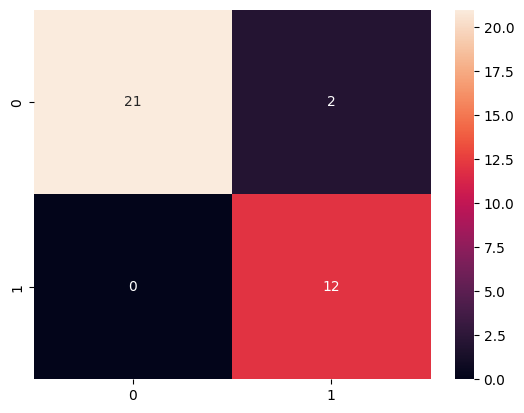

In [20]:
color = 'white'
matrix = confusion_matrix(y, y_pred)
sns.heatmap(matrix, annot=True)

print(accuracy_score(y, y_pred))
print(recall_score(y, y_pred))
print(precision_score(y, y_pred))

In [21]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.

# model.save('txt_classification.h5')